In [1]:
from netCDF4 import Dataset
import datetime
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib.dates import date2num 
import matplotlib.dates as mdates
from pytz import timezone
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['timezone'] = timezone("US/Central")



nc = Dataset("../data/NDFD_NWS_CONUS_conduit_2p5km_20160830_2200.grib2.nc")


stime = timezone('UTC').localize(datetime.datetime(2016, 8, 30, 22, 0))

def kelvin2deg(K):
    
    return np.array(K * 9/5 - 459.67)

print(nc.variables['lat'][338, 394], nc.variables['lon'][338, 394])

42.4420438977 -88.7545294101


Placeholder garbage for reading in data.. I'm going to assume that this will be changed in the future

In [2]:
td = nc.variables['Dewpoint_temperature_surface']
t = nc.variables['Temperature_surface'] 
wsp = nc.variables['Wind_speed_surface']
wdir = nc.variables['Wind_direction_from_which_blowing_surface']
tcld = nc.variables['Total_cloud_cover_surface']
rhmd = nc.variables['Relative_humidity_surface']

ppop = nc.variables['Total_precipitation_surface_12_Hour_Accumulation_probability_above_0p254']

dewpoint = kelvin2deg(td[:, 338, 394])
temp = kelvin2deg(t[:, 338, 394])
wspeed = np.array(wsp[:, 338, 394])
wdirection = np.deg2rad(wdir[:, 338, 394])
percentcloud = np.array(tcld[:, 338, 394])
relativehumidity = np.array(rhmd[:,338, 394])
precip_prob = np.array(ppop[:, 338, 394])

u = -wspeed * np.sin(wdirection)
v = -wspeed * np.cos(wdirection)

#different times for different variables... uuughhhhhhhhhhhhhhhhhhh
hrs = np.array(nc.variables['time5'][:], dtype=int)
hrs_ppop = np.array(nc.variables['time'][:], dtype=int)

hours = np.array(list(range(np.min(hrs), np.max(hrs)+1)))

Create smoother lines by interpolating

In [4]:
#Generate the interpolation functions
td_smooth = UnivariateSpline(hrs, dewpoint, s=1)
t_smooth = UnivariateSpline(hrs, temp, s=1)
wsp_smooth = UnivariateSpline(hrs, wspeed, s=1)
tcld_smooth = UnivariateSpline(hrs, percentcloud, s=1)
rlmd_smooth = UnivariateSpline(hrs, relativehumidity, s=1)
ppop_smooth = UnivariateSpline(hrs_ppop, precip_prob, s=1)


#original times, each value is hours since start time
time = np.array([stime + datetime.timedelta(hours=h) for h in hrs.astype(float)])

#times to interpolate to
time_smooth = np.array([stime + datetime.timedelta(hours=h) for h in hours.astype(float)])

Multiple axes to get that authentic NWS website feel

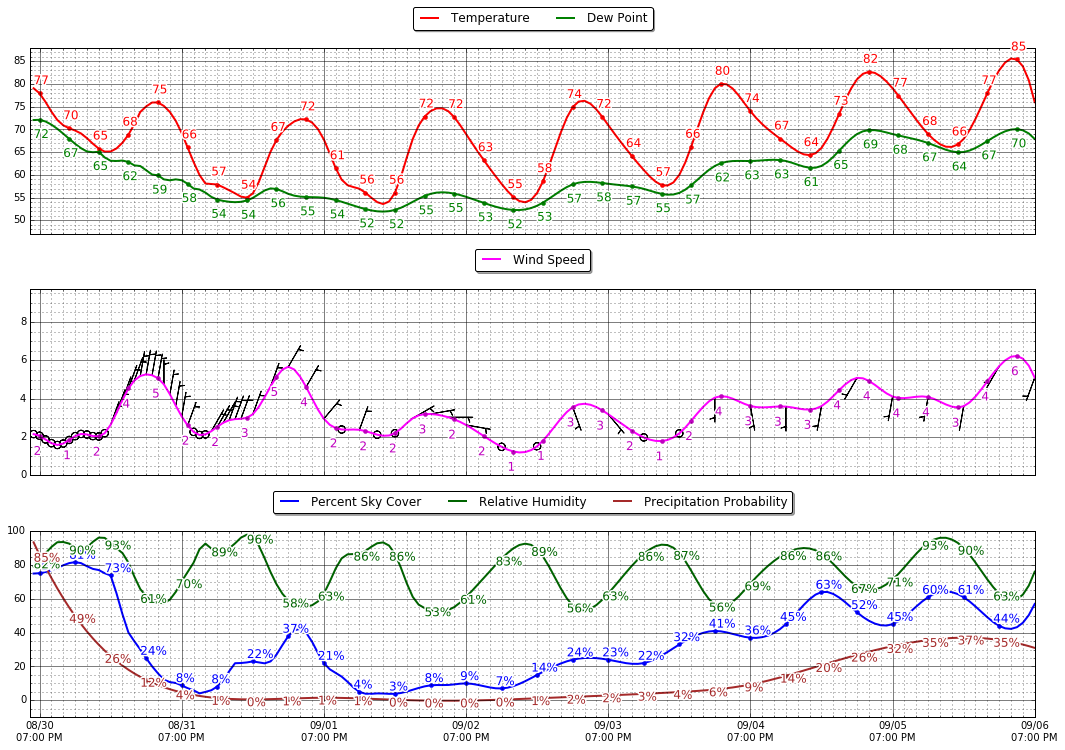

In [5]:
#set up first axis
ax1 = plt.subplot(3, 1, 1)

#plot temperature line
ax1.plot(time_smooth, t_smooth(hours), "r-", linewidth=2, label="Temperature")

#plot dewpoint line
ax1.plot(time_smooth, td_smooth(hours), "g-", linewidth=2, label="Dew Point")

#plot temp and dewpoint rounded values at some time interval
#plot dots to denote where this value belongs
#TODO.. why am I off by one?
for h in hours[1:-1:5]:
    ax1.text(time_smooth[h] - datetime.timedelta(hours=2), 
             t_smooth(h)+2, str(int(t_smooth(h))), color='r', fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax1.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             t_smooth(h), "r.", markersize=8)
    
    ax1.text(time_smooth[h] - datetime.timedelta(hours=2), 
             td_smooth(h)-4, str(int(td_smooth(h))), color='g', fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax1.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             td_smooth(h), "g.", markersize=8)
    

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), 
           ncol=3, fancybox=True, shadow=True)

#axis housekeeping
ax1.set_ylim(np.min(dewpoint) - 5, np.max(temp) + 5 )
ax1.grid(b=True, which='major', color='k', linestyle='-')
ax1.grid(b=True, which='minor', color='k', linestyle=':')
ax1.minorticks_on()
plt.setp(ax1.get_xticklabels(), visible=False)

#set up second axis, share x axis with ax1
ax2 = plt.subplot(3, 1, 2, sharex=ax1)

#plot wind speed over time
ax2.plot(time_smooth, wsp_smooth(hours), linewidth=2, color="magenta", label="Wind Speed")

#plot wind barbs that follow line
ax2.barbs(date2num(time_smooth[hrs-1]), wsp_smooth(hrs), u, v)

#same as in ax1
for h in hours[1:-1:5]:
    ax2.text(time_smooth[h] - datetime.timedelta(hours=2), 
             wsp_smooth(h)-1, str(int(wsp_smooth(h))), color='m', fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax2.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             wsp_smooth(h), "m.", markersize=8)

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
           ncol=3, fancybox=True, shadow=True)

#ax2 housekeeping
ax2.set_ylim(0, np.max(wspeed) + 4)
ax2.grid(b=True, which='major', color='k', linestyle='-')
ax2.grid(b=True, which='minor', color='k', linestyle=':')
ax2.minorticks_on()
plt.setp(ax2.get_xticklabels(), visible=False)

#set up 3rd axis
ax3 = plt.subplot(3, 1, 3, sharex=ax1)

#plot 3 variable lines
ax3.plot(time_smooth, tcld_smooth(hours), linewidth=2, color="blue", label="Percent Sky Cover")
ax3.plot(time_smooth, rlmd_smooth(hours), linewidth=2, color="darkgreen", label="Relative Humidity")
ax3.plot(time_smooth, ppop_smooth(hours), linewidth=2, color="brown", label="Precipitation Probability")

#same as ax1 and ax2
for h in hours[1:-1:6]:
    ax3.text(time_smooth[h] - datetime.timedelta(hours=2), 
             tcld_smooth(h)+2, str(int(tcld_smooth(h)))+"%", color='b', fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax3.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             tcld_smooth(h), "b.", markersize=8)
    
    ax3.text(time_smooth[h] - datetime.timedelta(hours=2), 
             rlmd_smooth(h)-4, str(int(rlmd_smooth(h)))+"%", color="darkgreen", fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax3.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             rlmd_smooth(h), color="darkgreen", marker='.', markersize=8)
    
    ax3.text(time_smooth[h] - datetime.timedelta(hours=2), ppop_smooth(h)-4, 
             str(int(ppop_smooth(h)))+"%", color='brown', fontsize=12,
             path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    ax3.plot(time_smooth[h] - datetime.timedelta(hours=1), 
             ppop_smooth(h), color='brown', marker='.', markersize=8)

ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
           ncol=3, fancybox=True, shadow=True)

#ax3 housekeeping
ax3.set_ylim(-10, 100)
ax3.grid(b=True, which='major', color='k', linestyle='-')
ax3.grid(b=True, which='minor', color='k', linestyle=':')
ax3.minorticks_on()

#We only want to plot xaxis labels on bottom axis
#custom format of date
myFmt = mdates.DateFormatter('%m/%d\n%I:%M %p')
ax3.xaxis.set_major_formatter(myFmt)

#custom frequency of minor ticks
minorLocator = AutoMinorLocator(12)
ax3.xaxis.set_minor_locator(minorLocator)

#reduce space between the axes
plt.subplots_adjust(hspace = .3)